## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
print(tf.__version__)

2.6.0


### Get the dataset

In [3]:
training_dir = '../dataset/training'
validation_dir = '../dataset/validation'
test_dir = '../dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [4]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 10320 files belonging to 6 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


### Explore the training dataset

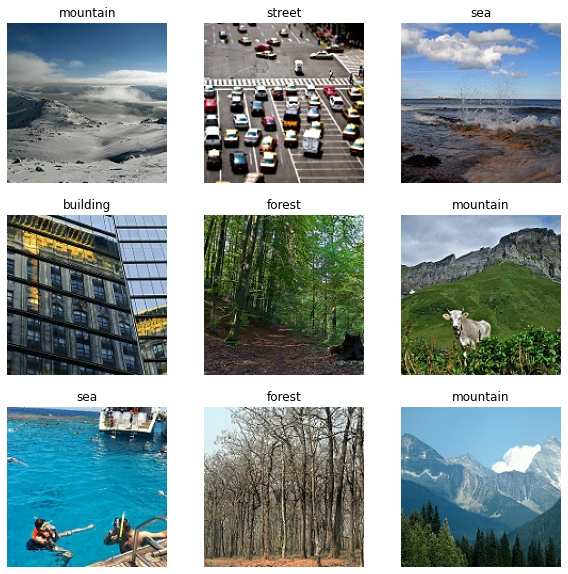

In [6]:
class_names = training_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

### Data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

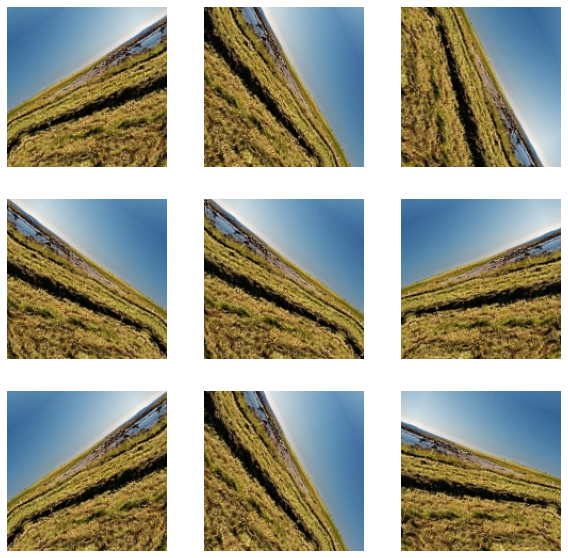

In [8]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model Development And Training

### Rescale pixel values

We will use `tf.keras.applications.MobileNetV2` as our base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Creation of the base model using a CNN architecture

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [13]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [14]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model (Feature extraction)

In [15]:
from tensorflow.keras.optimizers import Adam

base_learning_rate = 0.0001

opt = Adam(learning_rate=base_learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 150, 150, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0     

In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

81/81 [==============================] - 82s 957ms/step - loss: 2.2958 - accuracy: 0.1597
initial loss: 2.30
initial accuracy: 0.16


### Model training

In [18]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
323/323 [==============================] - 400s 1s/step - loss: 1.2768 - accuracy: 0.5220 - val_loss: 0.6695 - val_accuracy: 0.7760
Epoch 2/10
323/323 [==============================] - 390s 1s/step - loss: 0.6752 - accuracy: 0.7556 - val_loss: 0.4720 - val_accuracy: 0.8450
Epoch 3/10
323/323 [==============================] - 400s 1s/step - loss: 0.5477 - accuracy: 0.8016 - val_loss: 0.3985 - val_accuracy: 0.8659
Epoch 4/10
323/323 [==============================] - 384s 1s/step - loss: 0.4705 - accuracy: 0.8257 - val_loss: 0.3582 - val_accuracy: 0.8748
Epoch 5/10
323/323 [==============================] - 381s 1s/step - loss: 0.4303 - accuracy: 0.8401 - val_loss: 0.3355 - val_accuracy: 0.8802
Epoch 6/10
323/323 [==============================] - 380s 1s/step - loss: 0.4032 - accuracy: 0.8539 - val_loss: 0.3162 - val_accuracy: 0.8895
Epoch 7/10
323/323 [==============================] - 380s 1s/step - loss: 0.3952 - accuracy: 0.8530 - val_loss: 0.3028 - val_accuracy: 0.8942

In [19]:
base_model.trainable = True

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Recompile the model (Fine tuning)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 150, 150, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0     

### Continue training and save the model

In [22]:
fine_tuning_epochs = 10

total_epochs =  initial_epochs + fine_tuning_epochs

history = model.fit(training_dataset,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=validation_dataset)

Epoch 10/20
323/323 [==============================] - 1146s 3s/step - loss: 0.3078 - accuracy: 0.8881 - val_loss: 0.2299 - val_accuracy: 0.9236
Epoch 11/20
323/323 [==============================] - 1121s 3s/step - loss: 0.2393 - accuracy: 0.9115 - val_loss: 0.2185 - val_accuracy: 0.9194
Epoch 12/20
323/323 [==============================] - 1132s 4s/step - loss: 0.2128 - accuracy: 0.9260 - val_loss: 0.2319 - val_accuracy: 0.9190
Epoch 13/20
323/323 [==============================] - 1155s 4s/step - loss: 0.1890 - accuracy: 0.9316 - val_loss: 0.2835 - val_accuracy: 0.9008
Epoch 14/20
323/323 [==============================] - 1168s 4s/step - loss: 0.1708 - accuracy: 0.9407 - val_loss: 0.2266 - val_accuracy: 0.9264
Epoch 15/20
323/323 [==============================] - 1142s 4s/step - loss: 0.1494 - accuracy: 0.9458 - val_loss: 0.2101 - val_accuracy: 0.9283
Epoch 16/20
323/323 [==============================] - 1134s 4s/step - loss: 0.1400 - accuracy: 0.9505 - val_loss: 0.2345 - val_ac

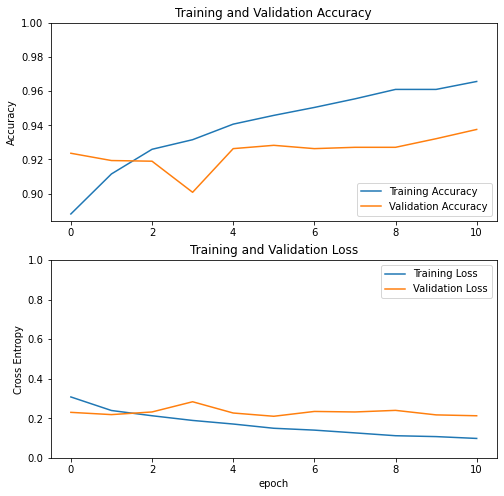

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save the model

In [24]:
model.save('../SavedModel/')

INFO:tensorflow:Assets written to: ../SavedModel/assets


In [25]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('../TFLiteModel/model.tflite', 'wb') as file:
    file.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/keras_save/assets
